# Drug Sensitivity to Anticancer Compounds

This notebook further explores the dataset used in my thesis. The [Cancer Therapeutic Response Portal](https://portals.broadinstitute.org/ctrp) contains additional information on the CCLE cell lines. Thus, we can collect the multi-omics measurements, annotations for histological subtypes and drug response curves for the cancer cell lines in the dataset.

In [1]:
import numpy as np
import pandas as pd

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

import seaborn as sns
import matplotlib.pyplot as plt

## 1. Explaination

These experiments measures the proliferation of cancer cells in vitro (in a well). The cells are counted using cytometry methods and the percentage of living to dead cancer cells is recorded as a reaction to increasing the dosage of a chemical compound.

|   Data	| Variable  	|   Description	|
|---	|---	|---	|
|   Cancer Cell Line	|  ccle_name 	|   unique identifier for the model cell line	|
|   Cancer Type	|   ccle_primary_site	|   organs of origin of the cell line tissues	|
|   Cancer Histology	|   ccle_primary_hist	|   general cell line histology type / categorization	|
|   Cancer Subtype	|   ccle_hist_subtype_1	|   specific cell line histology type / cluster	|
|   Drug Sensitivity (AUC)	|   area_under_curve	|   area under the dose response curve	|

In [2]:
# annotations of small-molecule drug compounds
compounds = pd.read_csv('../data/CTRPv2/v20.meta.per_compound.txt', sep='\t')
structure = compounds[['master_cpd_id', 'cpd_name', 'cpd_smiles']]

# corresponding cell line information from the viability screening assays
cell_lines = pd.read_csv('../data/CTRPv2/v20.meta.per_cell_line.txt', sep='\t')
experiments = pd.read_csv('../data/CTRPv2/v20.meta.per_experiment.txt', sep='\t')

## 2. Chemical Compound

Molecular structure: doxorubicin (FDA)
- inhibitor of topoisomerase II


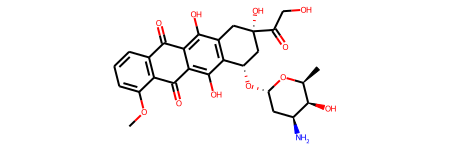

In [3]:
# select a molecule to display by its general name
cpd_index = compounds.loc[compounds.cpd_name == 'doxorubicin'].index.values[0]

# draw the molecules from the dataset
print('Molecular structure: {name} ({status})'.format(\
                name=compounds.cpd_name[cpd_index],
                status=compounds.cpd_status[cpd_index]))
print('-',compounds.target_or_activity_of_compound[cpd_index])

mol = Chem.MolFromSmiles(compounds.cpd_smiles[cpd_index])

mol

In [4]:
compounds.cpd_status.value_counts()

probe        343
clinical     100
FDA           73
GE-active     29
Name: cpd_status, dtype: int64

## 3. Dose-Response Plot

In [5]:
# dose-response curves, EC50 and AUC for each drug-cell line combination
doseresponse = pd.read_csv('../data/CTRPv2/v20.data.per_cpd_post_qc.txt', sep='\t')
acc_metrics = pd.read_csv('../data/CTRPv2/v20.data.curves_post_qc.txt', sep='\t')

dataset = doseresponse.merge(compounds).merge(experiments).merge(cell_lines).merge(acc_metrics, on=['experiment_id', 'master_cpd_id'])\
[['cpd_name', 'cpd_smiles', 'ccl_name', 'ccle_primary_site', 'ccle_primary_hist', 'ccle_hist_subtype_1', 'cpd_conc_umol', 'cpd_avg_pv', 'apparent_ec50_umol', 'area_under_curve']]

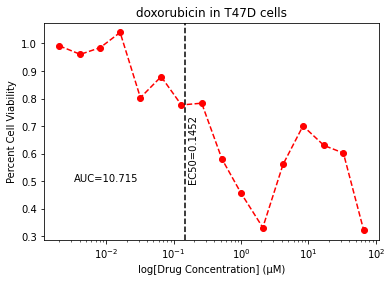

In [6]:
ccle_name = 'T47D'
cpd_name = compounds.cpd_name[cpd_index]

data = dataset.loc[(dataset.cpd_name == cpd_name) & (dataset.ccl_name == ccle_name)]

# draw dose response curve for the selected drug-cell line combination
plt.title('{compound} in {cellline} cells'.format(compound=cpd_name, cellline=ccle_name))
plt.plot(data.cpd_conc_umol, data.cpd_avg_pv, linestyle='--', marker='o', color='r')

# mark half-maximal concentration (EC50)
EC50 = data.apparent_ec50_umol.iloc[0]
plt.axvline(x=EC50, color='k', linestyle='--')
plt.text(EC50+0.11*EC50,0.5,'EC50={ec50}'.format(ec50=EC50), rotation=90)

AUC = data.area_under_curve.iloc[0]
plt.text(0.01,0.5,'AUC={auc}'.format(auc=AUC), horizontalalignment='center')

plt.xlabel('log[Drug Concentration] (µM)')
plt.ylabel('Percent Cell Viability')
plt.xscale('log')
plt.show()

## 4. Drug Sensitivity (AUC)

/Users/ramonreszat/Developer/affinity-graphs/thesis/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


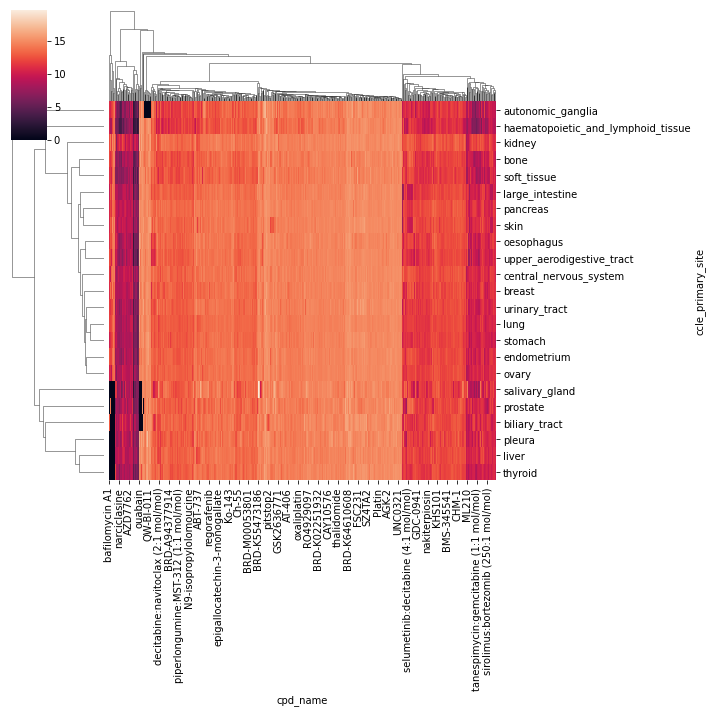

In [7]:
data = pd.pivot_table(dataset, values='area_under_curve',
        index=['ccle_primary_site'], columns=['cpd_name'],
        aggfunc=np.nanmean)

g = sns.clustermap(data.fillna(0.0), row_cluster=True,
        col_cluster=True)

## 5. Export Dataset

The final dataframe contains all drugs from the screening with their AUC and EC50 on each sample.

In [8]:
dataset = dataset.drop(columns=['cpd_conc_umol', 'cpd_avg_pv']).drop_duplicates()
dataset.to_csv('../data/drugs.csv', index=False)